<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/Kyra/SmoothGRADImplementation-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading in Data**

In [13]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'	   SmoothGradImplementation.ipynb
 cryptologywriteup.ipynb   SmoothGradIntro.ipynb
 dst			   VanillaGradIntro.ipynb
'Moral essay.gdoc'	   VanillaGrad.png


TO DO THIS, GO ON KAGGLE :https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

THEN DOWLOAD TO ZIP USINNG THE DOWLOAD BUTTON.

THEN ADD IT TO YOUR GOOGLE DRIVE AS A ZIP FILE.
THEN MYDIRVE/YOUR_NOTEBOOK/DATASET.ZIP


In [2]:
!unzip "/content/drive/MyDrive/dst/archive.zip" -d "/content/data"



Archive:  /content/drive/MyDrive/dst/archive.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(21

**Imports**

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import pearsonr

Loaded image: /content/data/Training/glioma_tumor/gg (217).jpg


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

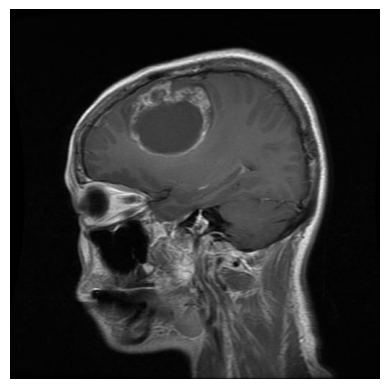

In [4]:
root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")


Dataset has now been loaded in. Now we need to transform the images by resizing and ToTensor and make dataloaders.

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))


In [6]:
#import matplotlib.pyplot as plt
#import torchvision

#plt.figure(figsize=(10,10))
#plt.imshow(torchvision.utils.make_grid(images[:16]).permute(1,2,0))
#plt.axis("off")


In [7]:
#import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Here we are using the Flexible CNN our team has built.

In [8]:
# Flexible CNN architecture to allow variable number of blocks
class FlexibleCNN(nn.Module):
    def __init__(self, n_layers, n_filters, kernel_sizes, dropout, fc_size):
        super(FlexibleCNN, self).__init__()

        blocks = []

        in_channels = 3

        for i in range(n_layers):

            # Get the parameters for the current convolutional layer
            out_channels = n_filters[i]
            kernel_size = kernel_sizes[i]

            padding = (kernel_size - 1) // 2

            # Individual CNN block
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

            # Add the newly created block to the list
            blocks.append(block)

            # Update the number of input channels for the next block
            in_channels = out_channels

        # Combine all blocks into a single feature extractor module
        self.features = nn.Sequential(*blocks)

        # Store hyperparameters needed for building the classifier later
        self.dropout = dropout
        self.fc_size = fc_size

        self.classifier = None

    def _create_classifier(self, flattened_size, device):
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(flattened_size, self.fc_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.fc_size, 4)
        ).to(device)

    def forward(self, x):
        device = x.device

        x = self.features(x)

        flattened = torch.flatten(x, 1)
        flattened_size = flattened.size(1)

        if self.classifier is None:
            self._create_classifier(flattened_size, device)

        return self.classifier(flattened)

In [9]:
best_params = {
    "n_layers": 4,
    "n_filters_0": 256,
    "n_filters_1": 80,
    "n_filters_2": 48,
    "n_filters_3": 240,
    "kernel_size_0": 3,
    "kernel_size_1": 5,
    "kernel_size_2": 3,
    "kernel_size_3": 5,
    "dropout": 0.1265531928742637,
    "fc_size": 400,
    "lr": 0.0008484833582874335
}

In [10]:
# Loading the optimal hyperparameters
n_layers = best_params["n_layers"]
n_filters = [best_params[f"n_filters_{i}"] for i in range(n_layers)]
kernel_sizes = [best_params[f"kernel_size_{i}"] for i in range(n_layers)]
dropout = best_params["dropout"]
fc_size = best_params["fc_size"]

learning_rate = best_params["lr"] # probably don't need this one

# Instantiating the CNN with specified hyper parameters
model = FlexibleCNN(n_layers, n_filters, kernel_sizes, dropout, fc_size).to(device)

# Loading the model with saved weights
#model.load_state_dict(torch.load("final_model.pth"))
model.eval()

FlexibleCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(256, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(80, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(48, 240, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
criterion = nn.CrossEntropyLoss()

In [14]:
epochs = 10

for epoch in range(epochs):
    model.train()               # set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{epochs}]  "
          f"Loss: {avg_loss:.4f}  "
          f"Acc: {train_accuracy:.2f}%")


Epoch [1/10]  Loss: 0.9536  Acc: 60.28%
Epoch [2/10]  Loss: 0.7383  Acc: 70.52%
Epoch [3/10]  Loss: 0.5990  Acc: 77.14%
Epoch [4/10]  Loss: 0.5099  Acc: 80.49%
Epoch [5/10]  Loss: 0.4286  Acc: 83.14%
Epoch [6/10]  Loss: 0.3677  Acc: 86.97%
Epoch [7/10]  Loss: 0.3187  Acc: 88.26%
Epoch [8/10]  Loss: 0.2719  Acc: 89.79%
Epoch [9/10]  Loss: 0.2428  Acc: 91.01%
Epoch [10/10]  Loss: 0.2177  Acc: 91.53%


Choose our device - CPU.

In [15]:
torch.save(model.state_dict(), "flexiblecnn_mri.pth")
model.load_state_dict(torch.load("flexiblecnn_mri.pth", map_location=device))

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total * 100
print("Test Accuracy:", test_acc)


Test Accuracy: 69.28934010152284


**SmoothGrad Implementation**

In [16]:
def compute_smoothgrad(model, image_tensor, target_class, device,
                       n_samples=50, stdev=0.15, magnitude=True):
    """
    SmoothGrad implementation.
    Adds Gaussian noise to input and averages gradient saliency.
    Choose sigma=0.15 for reasons shown in SmoothGrad intro
    """

    model.eval()

    # Convert input to numpy for noise sampling
    x_np = image_tensor.clone().detach().cpu().numpy()
    img_min, img_max = x_np.min(), x_np.max()
    noise_std = stdev * (img_max - img_min)

    total_gradients = np.zeros_like(x_np)

    for i in range(n_samples):

        # Add Gaussian noise
        noise = np.random.normal(0, noise_std, size=x_np.shape).astype(np.float32)
        noisy_input = x_np + noise

        noisy_tensor = torch.from_numpy(noisy_input).to(device)
        noisy_tensor.requires_grad_(True)

        # Forward
        output = model(noisy_tensor)
        score = output[0, target_class]

        # Backward
        model.zero_grad()
        score.backward()

        grads = noisy_tensor.grad.detach().cpu().numpy()

        # Accumulate gradients
        if magnitude:
            total_gradients += grads * grads
        else:
            total_gradients += np.abs(grads)

    # Average
    avg_grad = total_gradients[0] / n_samples  # remove batch dim
    saliency = np.max(avg_grad, axis=0)

    # Normalise [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency

The importance of $\sigma $:

When we add Gaussian noise to each pixel realisation $x$, we add it by:

$x_i = x + \epsilon_i,      $ where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$.

In this simulation, I randomly sampled images from the set and produced their saliency maps after adding various levels of Gaussian noise.

I have selected 3 in particular here to showcase SmoothGrad's perfomance.

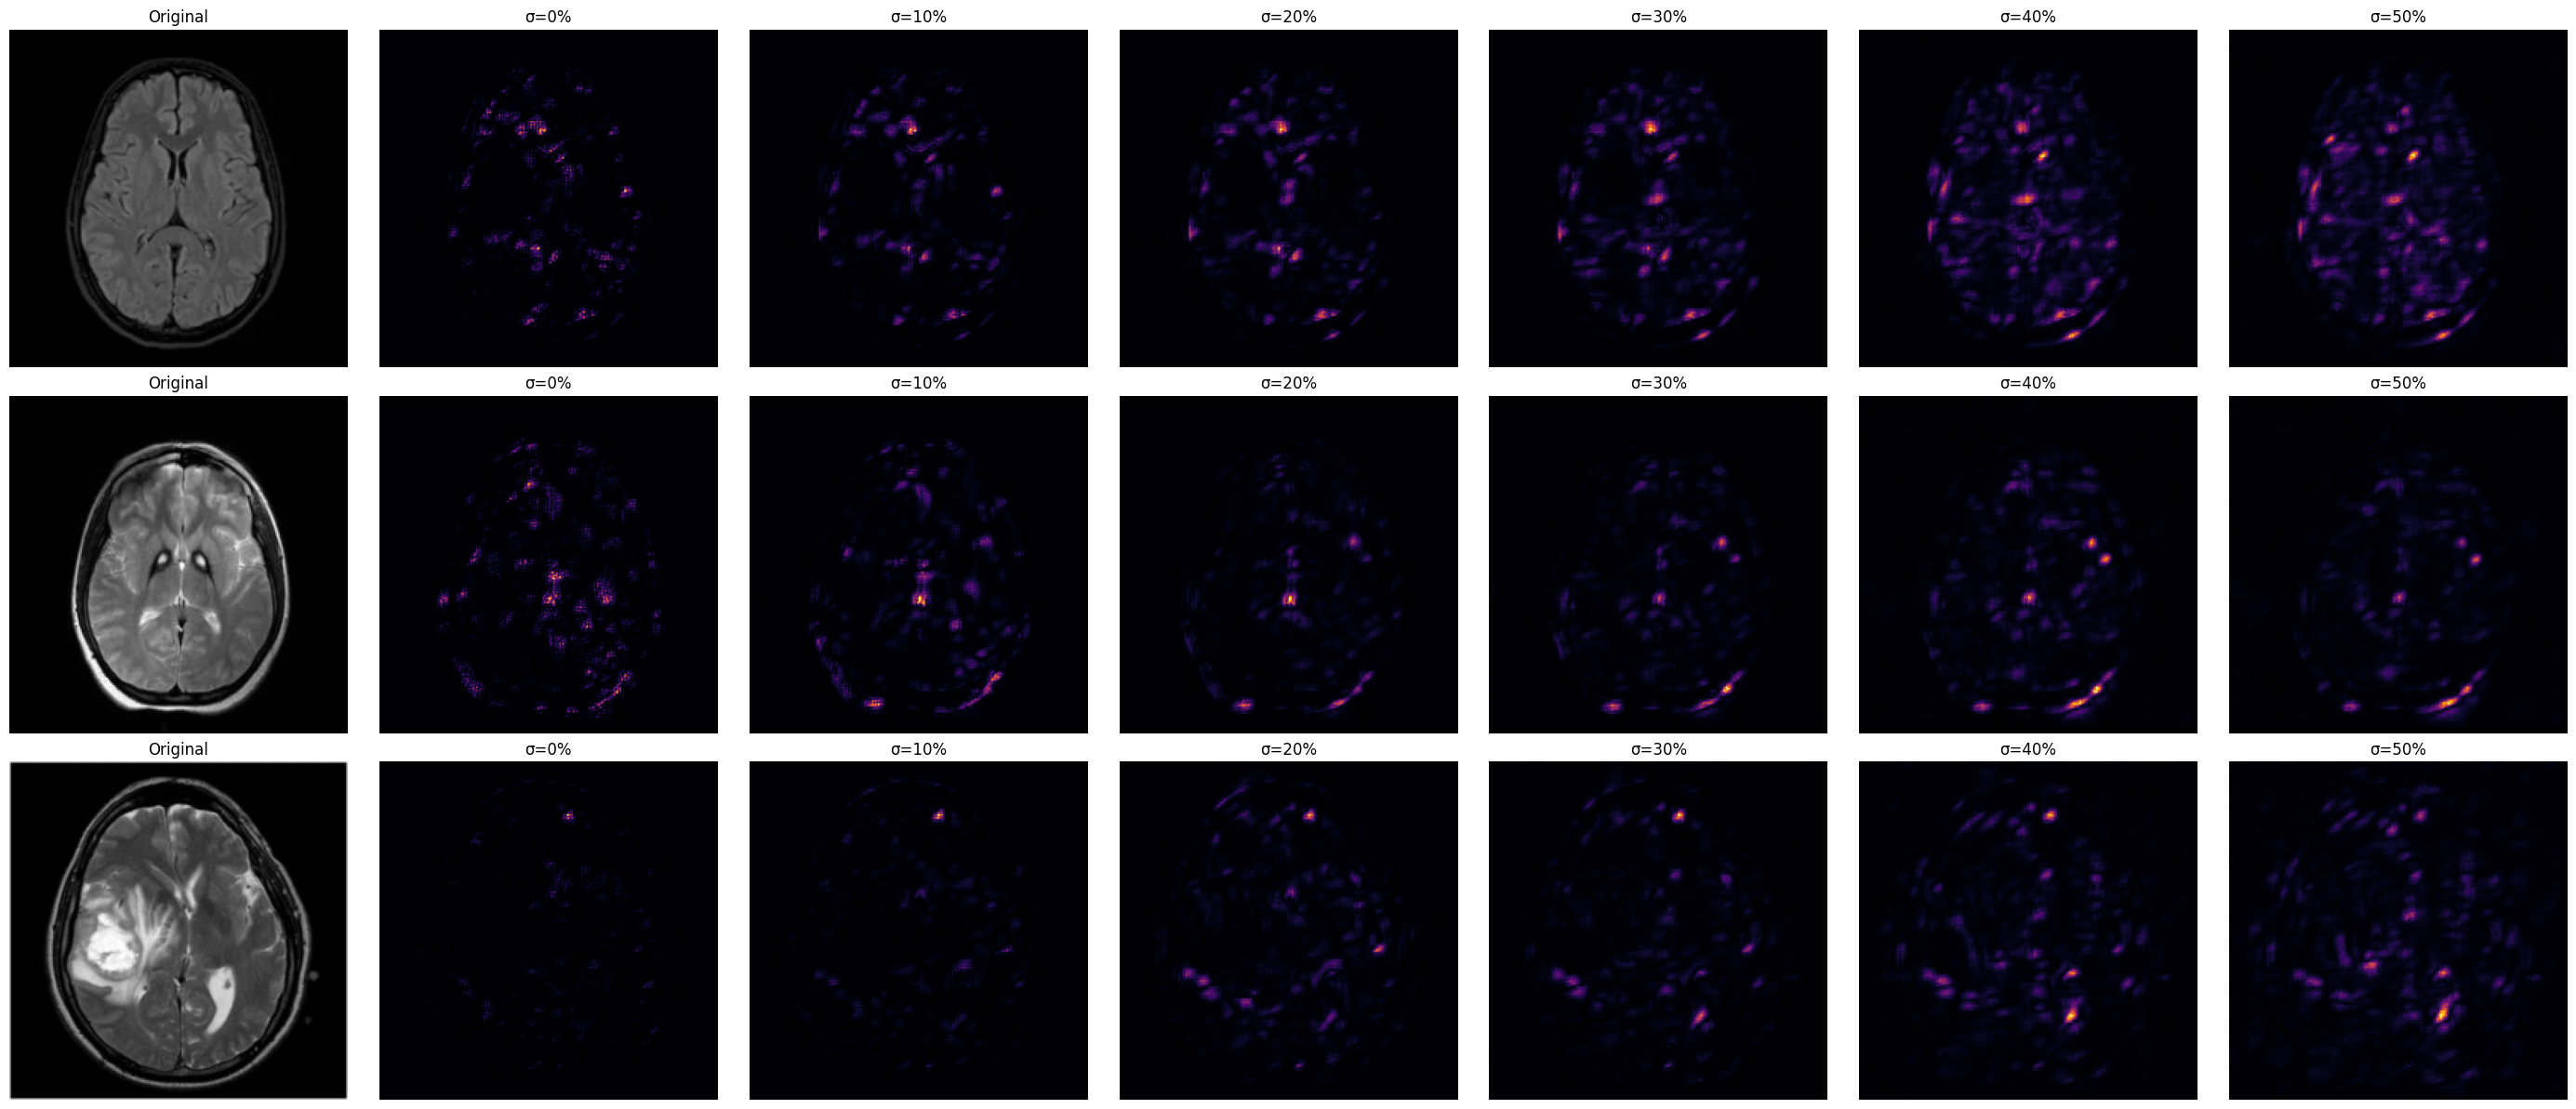

In [18]:
sigma_values = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50]

def sigma_simulations(sigma_values):
  example_imgs = []
  example_labels = []

  # choose 3 random images to compare
  # Making note of indices that show patterns: [217, 292, 20]
  #indices = random.sample(range(len(test_dataset)), 3)
  indices = [217, 292, 20]
  # print(indices)

  for idx in indices:
      img, label = test_dataset[idx]
      example_imgs.append(img.unsqueeze(0))  # make shape [1,3,224,224]
      example_labels.append(label)

  all_smoothgrads = []

  for img, label in zip(example_imgs, example_labels):
      img = img.to(device)
      img_sgs = {}

      for sigma in sigma_values:

          sg_map = compute_smoothgrad(
              model, img, label, device,
              n_samples=50,
              stdev=sigma
          )

          img_sgs[sigma] = sg_map

      all_smoothgrads.append(img_sgs)

  num_imgs = len(example_imgs)
  num_sigmas = len(sigma_values)

  fig, axs = plt.subplots(num_imgs, num_sigmas+1, figsize=(4*(num_sigmas+1), 4*num_imgs))

  for row in range(num_imgs):

      original = example_imgs[row][0].permute(1,2,0).cpu().numpy()
      axs[row, 0].imshow(original)
      axs[row, 0].set_title("Original")
      axs[row, 0].axis("off")

      # Fill in SmoothGrad maps
      for col, sigma in enumerate(sigma_values, start=1):
          axs[row, col].imshow(all_smoothgrads[row][sigma], cmap='inferno')
          axs[row, col].set_title(f"σ={int(sigma*100)}%")
          axs[row, col].axis("off")

  plt.tight_layout()
  plt.show()

  return None

sigma_simulations(sigma_values)


We can see from this output that at $\sigma = 0$, there isn't much definition in our saliency map. This is equivalent to the vanilla saliency map.

As $\sigma$ increases, structures in the image become more clear, but we can see the maps getting hazier and picking up on structures not in the original image as $\sigma$ passes its optimal value.

Take the 3rd row for example: we can see there's a highlighted section on the left hand side of the brain. At values of $σ = ${$0.1, 0.2, 0.3$} this region is highlighted in the map, showing SmoothGrad is working. But as we get to $50%$ we can see that SmoothGrad is printing oval structures around the shape of the head - this isn't originally there and is a false prediction due to the excess noise.

Using these maps, the optimal value looks to be between 10 and 20%, but let's check closer.

In [ ]:
sigma_values = [0.10, 0.15, 0.20, 0.25]

sigma_simulations(sigma_values)


As we thought, 25% is too high and irrelevant structures are appearing in the map. 15% seems to be the perfect combination of highlighting the structures without adding any noise.

**Evaluating SmoothGrad's Stability:**

To best display SmoothGrad's improvement in stability, we have opted to compare it to Vanilla Grad as a baseline. Below is a simple VanillaGrad implementation and a visualisation of their saliency maps for a randomly sampled image.

In [ ]:
def compute_vanilla_saliency(model, image_tensor, target_class, device):
    """
    Compute vanilla gradient saliency map for a single input image.
    image_tensor: shape [1, C, H, W]
    """

    model.eval()
    image_tensor = image_tensor.clone().detach().to(device)
    image_tensor.requires_grad_(True)

    # Forward pass - computes logits f(x)
    output = model(image_tensor)
    score = output[0, target_class]

    # Backward pass - compute gradient at target class
    model.zero_grad()
    score.backward()
    grads = image_tensor.grad.detach().cpu().numpy()[0]

    # Reduce channels to 2d
    saliency = np.max(np.abs(grads), axis=0)

    # Normalise to [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency


In [ ]:
def show_saliency_comparison(original_img, vanilla_map, smoothgrad_map):
    fig, axs = plt.subplots(1, 3, figsize=(16,5))

    axs[0].imshow(original_img, cmap='gray')
    axs[0].set_title("Original MRI")
    axs[0].axis('off')

    axs[1].imshow(vanilla_map, cmap='gray')
    axs[1].set_title("Vanilla Gradient Saliency")
    axs[1].axis('off')

    axs[2].imshow(smoothgrad_map, cmap='gray')
    axs[2].set_title("SmoothGrad Saliency")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Prepare a test image
images, labels = next(iter(test_loader))

img = images[0].unsqueeze(0).to(device)   # [1,3,224,224]
target_class = labels[0].item()

# Compute saliency maps
vanilla_map = compute_vanilla_saliency(model, img, target_class, device)
smooth_map  = compute_smoothgrad(model, img, target_class, device,
                                 n_samples=50, stdev=0.15)

# Visualise
show_saliency_comparison(
    original_img = images[0].permute(1,2,0).cpu().numpy(),
    vanilla_map = vanilla_map,
    smoothgrad_map = smooth_map
)


On the right we can clearly see the shapes of the tumor area coming through - the loops in the highlighted region are much clearer in the SmoothGrad saliency map.

**Adding Pertubation to Investigate Robustness of Methods:**

SmoothGrad improves predictive power by adding internal Gaussian noise to multiple realisations of the original image $x$ and averaging across the ensemble, but what happens if we add external Gaussian noise $𝜍$ ? This is a pertubation producing a new image $x'$ and demonstrates the robustness of each technique.

$ x' = x + 𝜍$

Assuming SmoothGrad is more stable than VanillaGrad as we should expect, the saliency map should be less sensitive to this change than VanillaGrad. To compare the quantitatively rather than just what we think *looks* most stable, we have chosen stability metrics L2 and Pearson Correlation.


**L2 Distance:**

The L2 distance measures the absoloute change in the saliency values between two saliency maps $S_1$ and $S_2$ (here between the methods on images $x$ and $x'$).

$ || S_1 - S_2 ||_2 = \sqrt{∑_i (S_1 - S_2)^2}$.

A small L2 distance indicates that the method is stable since the map is less sensitive to the noise. Therefore, we expect L2(SmoothGRAD) < L2(VanillaGRAD).


**Pearson Correlation Coefficient**

The CC measures the similarity between the shapes of the saliency maps rather than size of the similarity like L2 distance. It does this by breaking down the map by pixel and comparing all in the sum:

$CC(S_1,S_2)=\frac{\text{cov}(S_1,S_2)}{\sigma_{S_1}\sigma_{S_2}} =\frac{\sum_{i=1}^n(S_{1,i}-\bar{S}_1)(S_{2,i}-\bar{S}_2)}{\sqrt{\sum_{i=1}^n(S_{1,i}-\bar{S}_1)^2}\sqrt{\sum_{i=1}^n(S_{2,i}-\bar{S}_2)^2}} ∈ [-1, 1]
$

This complements L2 distance since we want to check whether both the magnitude and structures of the saliency map change. Therefore a large positive correlation means the technique is stable, so we shoudl expect SmoothGrad to have a larger CC than VanillaGrad.

I am only adding 5% to see the impact.


In [ ]:
def apply_small_perturbation(img_tensor, noise_std=0.05):
    """
    Applies a tiny Gaussian perturbation to test saliency stability.
    Note this is external not internal - not the same as how SmoothGrad uses Gaussian noise.
    """
    noise = torch.randn_like(img_tensor) * noise_std
    return img_tensor + noise


In [ ]:
#import numpy as np
#from scipy.stats import pearsonr

def compute_stability_metrics(map_original, map_perturbed):
    """
    Computes L2 distance and Pearson correlation between saliency maps.
    Higher correlation + lower L2 = more stable explanations.
    """
    flat_o = map_original.flatten()
    flat_p = map_perturbed.flatten()

    l2 = np.linalg.norm(flat_o - flat_p)
    corr = pearsonr(flat_o + 1e-8, flat_p + 1e-8)[0]  # numerical stability

    return l2, corr


In [ ]:
def run_stability_experiment(model, img, target_class, device, noise_std=0.02):

    img_tensor = img.unsqueeze(0).to(device)

    # Original saliency maps
    vanilla_orig = compute_vanilla_saliency(model, img_tensor, target_class, device)
    smooth_orig  = compute_smoothgrad(model, img_tensor, target_class, device)

    # Apply external input perturbation (not SmoothGrad noise)
    img_pert = apply_small_perturbation(img_tensor, noise_std=noise_std)

    # Perturbed saliency maps
    vanilla_pert = compute_vanilla_saliency(model, img_pert, target_class, device)
    smooth_pert  = compute_smoothgrad(model, img_pert, target_class, device)

    # Compute quantitative stability
    v_l2, v_corr = compute_stability_metrics(vanilla_orig, vanilla_pert)
    s_l2, s_corr = compute_stability_metrics(smooth_orig, smooth_pert)

    return {
        "vanilla_l2": v_l2, "vanilla_corr": v_corr,
        "smooth_l2":  s_l2, "smooth_corr":  s_corr,
        "vanilla_maps": (vanilla_orig, vanilla_pert),
        "smooth_maps":  (smooth_orig, smooth_pert)
    }


In [ ]:
# Pick a random test image
idx = np.random.randint(0, len(test_dataset))
img, label = test_dataset[idx]

target_class = label

results = run_stability_experiment(model, img, target_class, device)


In [ ]:
print("VanillaGrad Stability:")
print("  L2 distance: ", results["vanilla_l2"])
print("  Correlation:", results["vanilla_corr"])

print("\nSmoothGrad Stability:")
print("  L2 distance: ", results["smooth_l2"])
print("  Correlation:", results["smooth_corr"])

Our results are as we expected. SmoothGrad achieves a lower L2 distance and greater positive correlation coefficient than VanillaGrad, indicating it is a more stable technique which preserves the saliency map's structure better under noise pertubation.

In [ ]:
vanilla_orig, vanilla_pert = results["vanilla_maps"]
smooth_orig, smooth_pert   = results["smooth_maps"]

fig, axs = plt.subplots(2, 2, figsize=(8,8))

axs[0,0].imshow(vanilla_orig, cmap="gray")
axs[0,0].set_title("VanillaGrad (original)")
axs[0,0].axis("off")

axs[0,1].imshow(vanilla_pert, cmap="gray")
axs[0,1].set_title("VanillaGrad (perturbed)")
axs[0,1].axis("off")

axs[1,0].imshow(smooth_orig, cmap="gray")
axs[1,0].set_title("SmoothGrad (original)")
axs[1,0].axis("off")

axs[1,1].imshow(smooth_pert, cmap="gray")
axs[1,1].set_title("SmoothGrad (perturbed)")
axs[1,1].axis("off")

plt.tight_layout()
plt.show()


Performance Metric:

Our performance metric is AOPC-MoRF (Most Relevant First), which measures how quickly the model's performance drops after removing the k most important pixels. This essentially measures how accurate the interpretability method was in choosing the kth most important pixels for prediction.

We denote $x^{(k)}$ as the logit score with the top $k$ salient pixels removed.

$\text{AOPC}=\frac{1}{K}\sum_{k=1}^K [R_c(x)-R_c(x^{(k)})]$




In [ ]:
def compute_AOPC_MoRF(
    model,
    img_tensor,
    saliency_map,
    target_class,
    device,
    steps=50,
    baseline_value=0.0,
):
    """
    Computes AOPC using MoRF (Most Relevant First) perturbation.

    The idea:
    - Take the most important pixels (according to the saliency map),
    - Remove them progressively in increasing order (k pixels at a time),
    - Track how much the model’s prediction for the target class falls,
    - Average the drop across steps → AOPC.

    A good saliency method should cause the model’s score to drop
    quickly when its “most relevant” pixels are removed.
    """

    # ---------------------------
    # 1. Make sure everything is in order
    # ---------------------------
    model.eval()
    model.to(device)

    # Convert saliency map to numpy if needed
    sal_map_np = (
        saliency_map.detach().cpu().numpy()
        if isinstance(saliency_map, torch.Tensor)
        else np.array(saliency_map)
    )

    # Safety checks
    assert img_tensor.ndim == 4 and img_tensor.shape[0] == 1, \
        f"img_tensor must be [1,3,H,W], got {img_tensor.shape}"
    assert sal_map_np.ndim == 2, \
        f"saliency_map must be [H,W], got {sal_map_np.shape}"

    img_tensor = img_tensor.to(device)

    # ---------------------------
    # 2. Get the model’s original score for the target class
    # ---------------------------
    with torch.no_grad():
        original_score = model(img_tensor)[0, target_class].item()
        print(original_score)

    # ---------------------------
    # 3. Prepare the image + pixel ranking
    # ---------------------------
    # Work in numpy for masking convenience
    img_np = img_tensor.detach().cpu().numpy()[0]   # shape (C,H,W)
    C, H, W = img_np.shape

    # Flatten saliency into length H*W, and sort pixel indexes by importance
    flat_sal = sal_map_np.flatten()
    sorted_idx = np.argsort(-flat_sal)   # descending → MoRF

    total_pixels = H * W
    pixels_per_step = max(1, total_pixels // steps)

    score_drops = []

    # ---------------------------
    # 4. Main MoRF perturbation loop
    # ---------------------------
    for step in range(1, steps + 1):

        # Number of pixels masked at this step
        k = min(step * pixels_per_step, total_pixels)
        pixel_ids = sorted_idx[:k]

        # Work from a fresh copy of the original image (standard AOPC-MoRF)
        perturbed = img_np.copy()

        # Mask the same pixels across all channels
        for c in range(C):
            channel_flat = perturbed[c].reshape(-1)
            channel_flat[pixel_ids] = baseline_value
            perturbed[c] = channel_flat.reshape(H, W)

        # Convert back to a PyTorch tensor with batch dimension
        pert_tensor = (
            torch.from_numpy(perturbed)
            .unsqueeze(0)
            .float()
            .to(device)
        )

        # Forward pass on the perturbed image
        with torch.no_grad():
            new_score = model(pert_tensor)[0, target_class].item()

        # How much did the score fall at this step?
        score_drops.append(original_score - new_score)

    # ---------------------------
    # 5. AOPC = average score drop across all steps
    # ---------------------------
    AOPC = float(np.mean(score_drops))
    return AOPC, score_drops


In [ ]:
# Prepare a test image
images, labels = next(iter(test_loader))

img_tensor = images[0].unsqueeze(0)
target_class = labels[0].item()

# Compute saliency maps
vanilla_map = compute_vanilla_saliency(model, img_tensor, target_class, device)
smooth_map  = compute_smoothgrad(model, img_tensor, target_class, device,
                                 n_samples=50, stdev=0.15)


In [ ]:
AOPC_vanilla, drops_vanilla = compute_AOPC_MoRF(
    model=model,
    img_tensor=img_tensor,
    saliency_map=vanilla_map,
    target_class=target_class,
    device=device,
    steps=50
)

AOPC_smooth, drops_smooth = compute_AOPC_MoRF(
    model=model,
    img_tensor=img_tensor,
    saliency_map=smooth_map,
    target_class=target_class,
    device=device,
    steps=50
)

In [ ]:
print("AOPC vanilla:", AOPC_vanilla)
print("AOPC smoothgrad:", AOPC_smooth)


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(drops_vanilla, label="VanillaGrad", linewidth=3)
plt.plot(drops_smooth,  label="SmoothGrad", linewidth=3)

plt.xlabel("No. pixels masked (k)")
plt.ylabel("Score drop")
plt.title("MoRF Perturbation Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


**Graph Interpretation**

This graph is showing the impact of masking the most important pixels on the score of SmoothGrad and VanillaGrad. As expected, both lines quickly decrease as the most important classifying pixels are removed. As expected, the lines get shallower as k increases, since the pixels being removed here are less important.

Although the lines are relatively close together, SmoothGrad's score is consistently outperforming VanillaGrad as expected. This indicates that it's better at identifying the most important pixels and is less sensitive to MoRF petrubation.

This demonstrates perfectly our mathematical motivation behind SmoothGrad: by adding Gaussian noise and aggregating over an ensemble of simulations SmoothGrad reduces gradient fluctuations and finds the important structures in the input images, outperforming the baseline VanillaGrad.

**Appendix - Using a simple CNN**

Here, I have used a simple CNN which these models were originally trained on for comparison.

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 224 → 112

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 112 → 56
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 64),
            nn.ReLU(),
            nn.Linear(64, len(train_dataset.classes)),
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


In [20]:
model = SimpleCNN().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [21]:
epochs = 10   # you can increase this later

for epoch in range(epochs):
    model.train()               # set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss accumulation
        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{epochs}]  "
          f"Loss: {avg_loss:.4f}  "
          f"Acc: {train_accuracy:.2f}%")


Epoch [1/10]  Loss: 1.1233  Acc: 51.50%
Epoch [2/10]  Loss: 0.7511  Acc: 69.27%
Epoch [3/10]  Loss: 0.6247  Acc: 74.95%
Epoch [4/10]  Loss: 0.5393  Acc: 78.95%
Epoch [5/10]  Loss: 0.4777  Acc: 81.78%
Epoch [6/10]  Loss: 0.4461  Acc: 82.93%
Epoch [7/10]  Loss: 0.3978  Acc: 85.19%
Epoch [8/10]  Loss: 0.3564  Acc: 86.69%
Epoch [9/10]  Loss: 0.3133  Acc: 88.61%
Epoch [10/10]  Loss: 0.2911  Acc: 89.27%


In [22]:
torch.save(model.state_dict(), "simplecnn_mri.pth")
model.load_state_dict(torch.load("simplecnn_mri.pth", map_location=device))

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total * 100
print("Test Accuracy:", test_acc)


Test Accuracy: 60.913705583756354


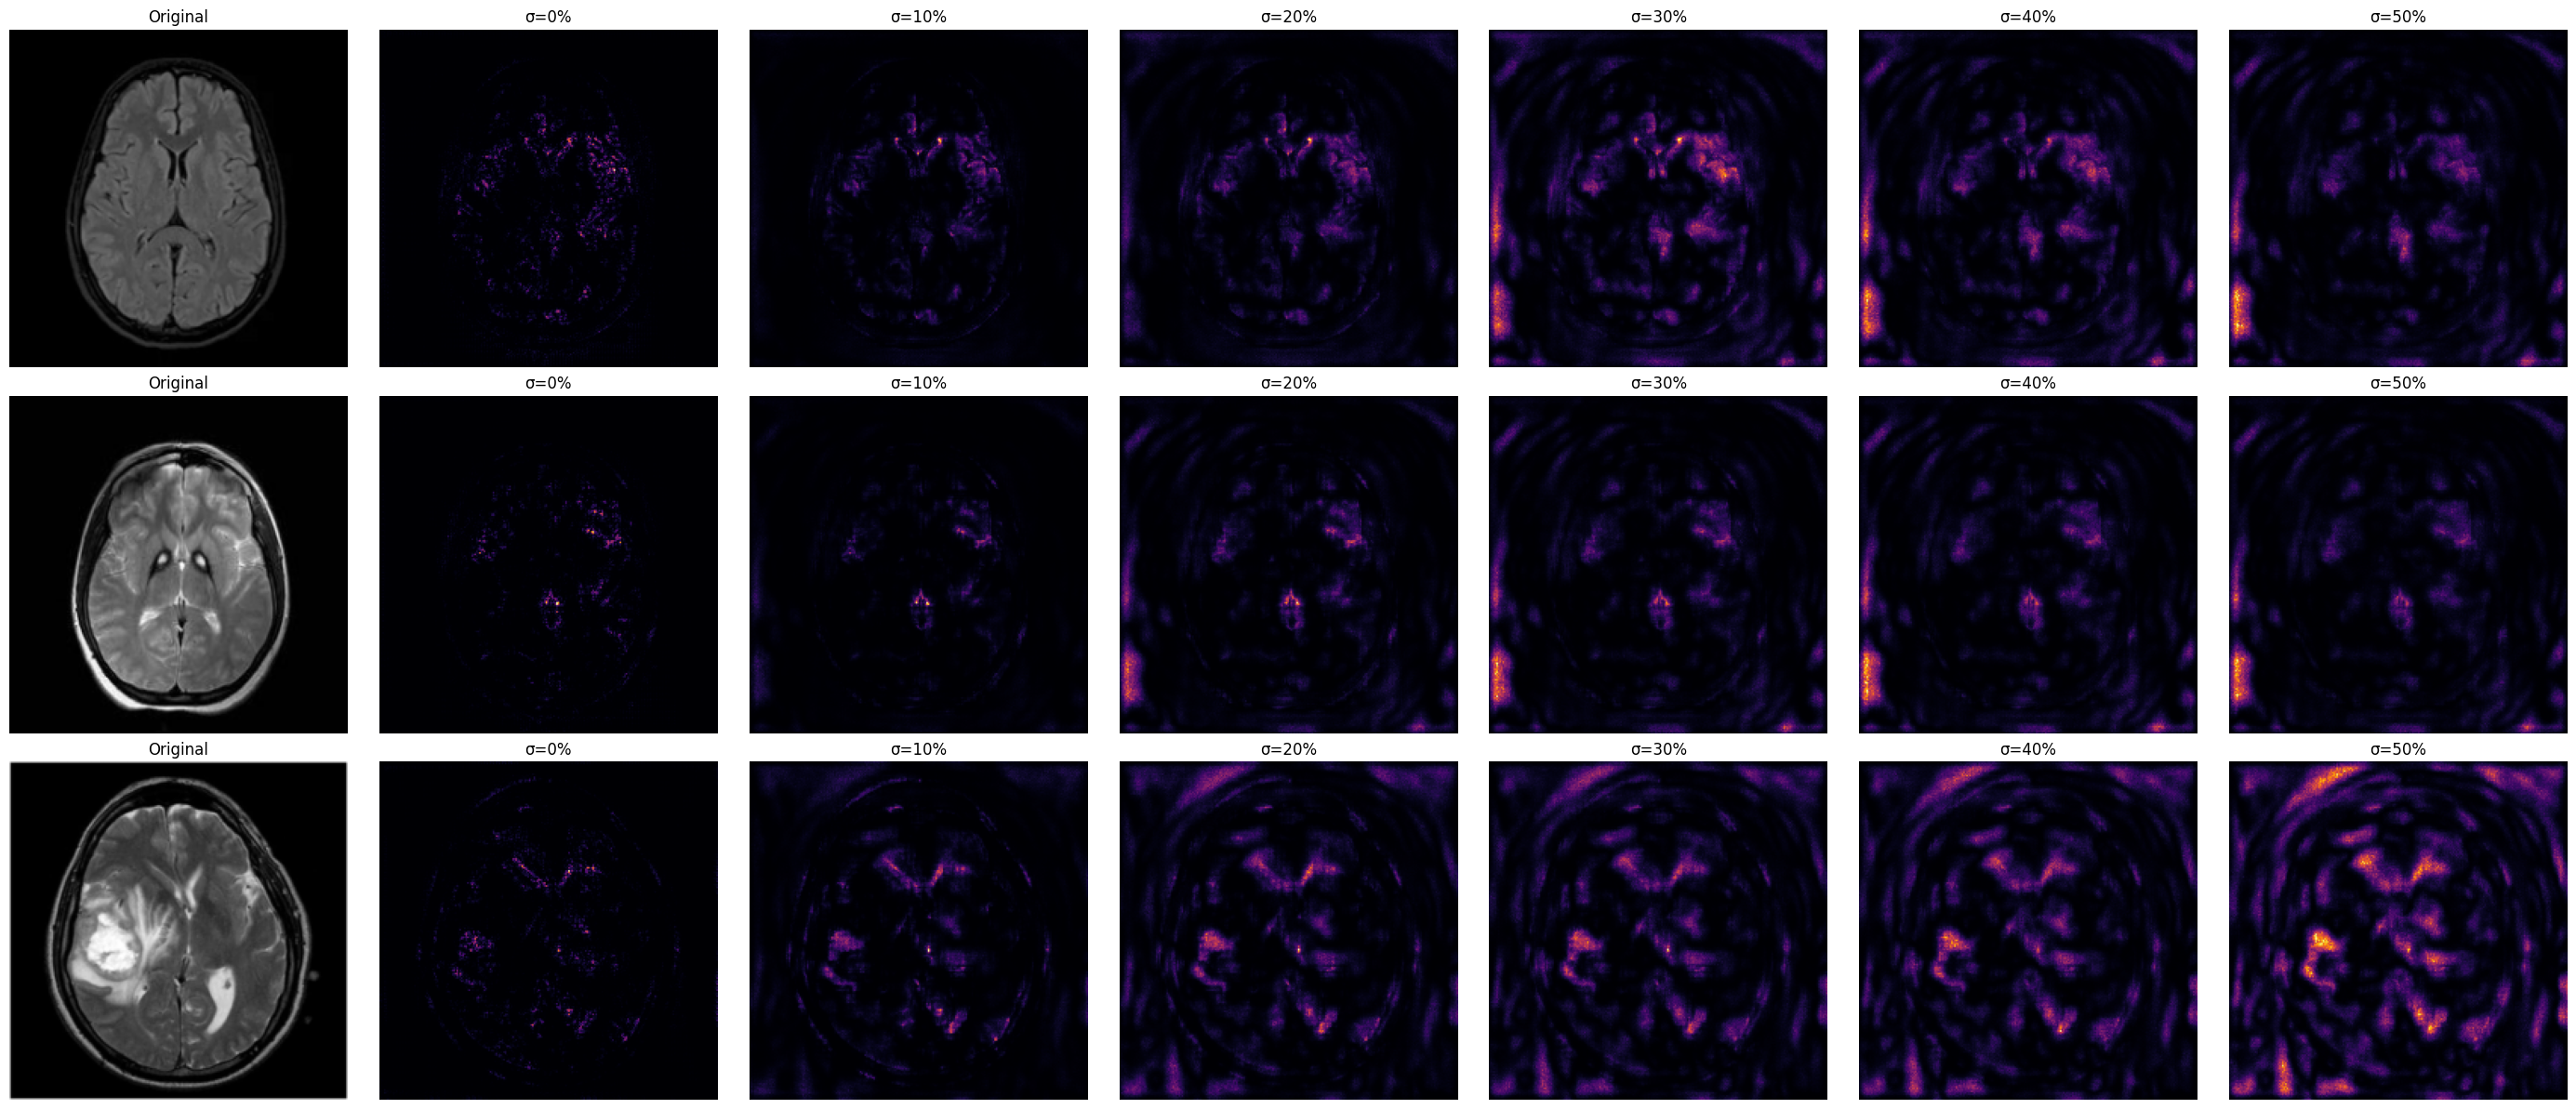

In [23]:
sigma_values = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50]

def sigma_simulations(sigma_values):
  example_imgs = []
  example_labels = []

  # choose 3 random images to compare
  # Making note of indices that show patterns: [217, 292, 20]
  #indices = random.sample(range(len(test_dataset)), 3)
  indices = [217, 292, 20]
  # print(indices)

  for idx in indices:
      img, label = test_dataset[idx]
      example_imgs.append(img.unsqueeze(0))  # make shape [1,3,224,224]
      example_labels.append(label)

  all_smoothgrads = []

  for img, label in zip(example_imgs, example_labels):
      img = img.to(device)
      img_sgs = {}

      for sigma in sigma_values:

          sg_map = compute_smoothgrad(
              model, img, label, device,
              n_samples=50,
              stdev=sigma
          )

          img_sgs[sigma] = sg_map

      all_smoothgrads.append(img_sgs)

  num_imgs = len(example_imgs)
  num_sigmas = len(sigma_values)

  fig, axs = plt.subplots(num_imgs, num_sigmas+1, figsize=(4*(num_sigmas+1), 4*num_imgs))

  for row in range(num_imgs):

      original = example_imgs[row][0].permute(1,2,0).cpu().numpy()
      axs[row, 0].imshow(original)
      axs[row, 0].set_title("Original")
      axs[row, 0].axis("off")

      # Fill in SmoothGrad maps
      for col, sigma in enumerate(sigma_values, start=1):
          axs[row, col].imshow(all_smoothgrads[row][sigma], cmap='inferno')
          axs[row, col].set_title(f"σ={int(sigma*100)}%")
          axs[row, col].axis("off")

  plt.tight_layout()
  plt.show()

  return None

sigma_simulations(sigma_values)


In [ ]:
# Prepare a test image
images, labels = next(iter(test_loader))

img_tensor = images[0].unsqueeze(0)
target_class = labels[0].item()

# Compute saliency maps
vanilla_map = compute_vanilla_saliency(model, img_tensor, target_class, device)
smooth_map  = compute_smoothgrad(model, img_tensor, target_class, device,
                                 n_samples=50, stdev=0.15)


In [ ]:
AOPC_vanilla, drops_vanilla = compute_AOPC_MoRF(
    model=model,
    img_tensor=img_tensor,
    saliency_map=vanilla_map,
    target_class=target_class,
    device=device,
    steps=50
)

AOPC_smooth, drops_smooth = compute_AOPC_MoRF(
    model=model,
    img_tensor=img_tensor,
    saliency_map=smooth_map,
    target_class=target_class,
    device=device,
    steps=50
)

In [ ]:
print("AOPC vanilla (using simple CNN):", AOPC_vanilla)
print("AOPC smoothgrad (using simple CNN):", AOPC_smooth)


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(drops_vanilla, label="VanillaGrad", linewidth=3)
plt.plot(drops_smooth,  label="SmoothGrad", linewidth=3)

plt.xlabel("No. pixels masked (k)")
plt.ylabel("Score drop")
plt.title("MoRF Perturbation Curve with Simple CNN")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()
